#**Detecting Fake Reviews with Attention**





#*An Attention Layer from Scratch*

We think to ourselves that maybe, instead of having the LSTM figure out a compressed representation of the sequence in a 'fixed' manner, giving fixed 'weighting' or 'attention' to the particular words in a sequence, across observations, we should provide it the flexibility to decide which words are more or less important, depending on the joint set of words seen. This 'flexibility' to shift focus depending on the combinations of encountered tokens is exactly what attention seeks to achieve. We are going to implement an attention layer here, from scratch, which receives all the hidden states of the LSTM (rather than just the final hidden state), and it's going to provide the ability to highlight different words when constructing the sequence embedding, depending on the values that are present in the sequence. Here, we need one weight for each dimension of the embedding space that words were cast into. Imagine a 2D latent space, of long vs. short, and noun vs. not noun (or something - I made this up). Our weights might adapt under training to enable our model to focus more on long vs. short words, and nouns versus non-nouns, when formulating its prediction. Obviously, our embedding space captures latent semantic notions that we cannot articulate, but this is what it is doing conceptually.

Let's reimport and process our dataset as before.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

from google.colab import drive

drive.mount('/content/drive')
trip_advisor = pd.read_csv("drive/My Drive/Teaching/Courses/NYU - Modern AI/Session 4/datasets/deceptive-opinion.csv")

# Just load the data from the Week 3 folder again and shuffle.
trip_advisor = trip_advisor.sample(frac=1) # Shuffle the data since I'll eventually just use a simple validation split.

trip_advisor.describe(include='all')

# Or shuffle this way...
shuffled_indices= np.arange(trip_advisor.shape[0])
np.random.shuffle(shuffled_indices)

trip_advisor_text = trip_advisor['text'].to_numpy()
label = np.where(trip_advisor['deceptive']=='deceptive',1,0)

print(trip_advisor_text)
trip_advisor_text = trip_advisor_text[shuffled_indices]
label = label[shuffled_indices]
print(trip_advisor_text)

Mounted at /content/drive
['My wife and I stayed at the allegro this weekend while I was on a business trip. I was very impressed with their hospitality and my wife very much(maybe too much) enjoyed the in-house spa. Rooms service was a bit slow but, overall great hotel would stay again. \n'
 "I have stayed at the Omni off an on over the years. On business, for personal trips. This trip started off quite rocky, and left me very un-impressed. 1) Be aware, they have a new policy where they charge debit card $55 per day for 'incidentals' which you *may* incur. They do this if you elect not to use a standard credit card. Even if you have booked and paid for your room in advance. The desk clerk claimed 'all the hotels do this now'...funny how when I put a remote employee at the O'Hare hilton on my business debit card, I was never asked for additional funds. Having a policy is one thing, spreading blame for it is another. While not a problem for me, someone who plans trips down to the dollar

Let's make a TextVectorization() layer to preprocess our text.

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting multihot encodings (which means we'll have a fixed vector of 1's and 0's per review)
)

text_vectorization.adapt(trip_advisor_text)

We are going to start off with one-hot encodings again, just to make sure we understand the shapes of all the tensors and things as we go along, so we understand what the network is doing!

In [ ]:
processed_text = text_vectorization(trip_advisor_text)

# We have 1,600 reviews, with 2000 dummies for our vocab.
print(processed_text.shape)

(1600, 2000)


In [ ]:
processed_text[0]

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([1, 1, 1, ..., 0, 0, 0])>

Now we can make our network...

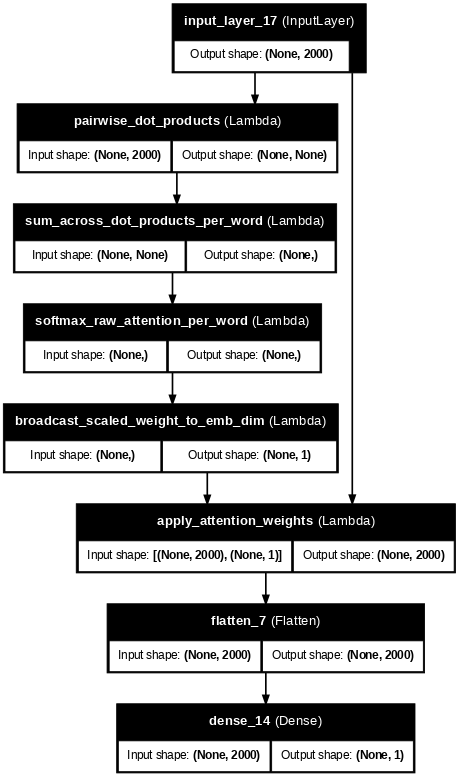

In [ ]:
from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda, Dense

def build_model():
    # Now, let's start specifying our model...
    inputs = keras.layers.Input(shape=processed_text.shape[1:]) # We take the sequence of 1-hot encodings as input.

    # 1. Calculate dot products between all pairs of word embeddings
    dot_products = Lambda(lambda x: tf.matmul(x, x, transpose_b=True),name="pairwise_dot_products")(inputs)  # (batch_size, seq_len, seq_len)

    # 2. Sum dot products for each word to get attention scores
    attention_scores = Lambda(lambda x: tf.reduce_sum(x, axis=-1),name="sum_across_dot_products_per_word")(dot_products)  # (batch_size, seq_len)

    # 3. Apply softmax to normalize attention scores
    attention_weights = Lambda(lambda x: tf.nn.softmax(x, axis=-1),name="softmax_raw_attention_per_word")(attention_scores)  # (batch_size, seq_len)

    # 4. Reshape attention weights for broadcasting
    attention_weights = Lambda(lambda x: tf.expand_dims(x, axis=-1),name="broadcast_scaled_weight_to_emb_dim")(attention_weights)  # (batch_size, seq_len, 1)

    # 5. Multiply embeddings by attention weights
    attention_output = Lambda(lambda x: x[0] * x[1],name="apply_attention_weights")([inputs, attention_weights])  # (batch_size, seq_len, embedding_dim)

    flattened = layers.Flatten()(attention_output)

    outputs = keras.layers.Dense(1, activation="sigmoid")(flattened)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()
keras.utils.plot_model(model,show_shapes=True,dpi=60,show_layer_names=True)

Let's get our data ready...

In [ ]:
data_train = processed_text[:1200]
labels_train = label[:1200]

data_test = processed_text[1200:]
labels_test = label[1200:]

And, let's try fitting this model... our custom attention layer actually does quite well!

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("attention_from_scratch.keras",
                                    save_best_only=True)
]

model = build_model()
history = model.fit(data_train, labels_train,
                        validation_split=0.2,
                        epochs=20, batch_size=1,callbacks=callbacks)

Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6182 - loss: 0.6550 - val_accuracy: 0.8500 - val_loss: 0.5104
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8731 - loss: 0.4555 - val_accuracy: 0.8667 - val_loss: 0.4115
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9193 - loss: 0.3410 - val_accuracy: 0.8583 - val_loss: 0.3655
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9252 - loss: 0.2872 - val_accuracy: 0.8667 - val_loss: 0.3307
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9192 - loss: 0.2575 - val_accuracy: 0.8625 - val_loss: 0.3064
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9198 - loss: 0.2291 - val_accuracy: 0.8708 - val_loss: 0.2942
Epoch 7/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9545 - loss: 0.1841 - val_accuracy: 0.8625 - val_loss: 0.2898
Epoch 8/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9555 - loss: 0.1657 - val_accuracy: 0.

And, plotting model performance, as well as evaluating against the test set, what do we get... our best model yields about 80% accuracy in the test data.

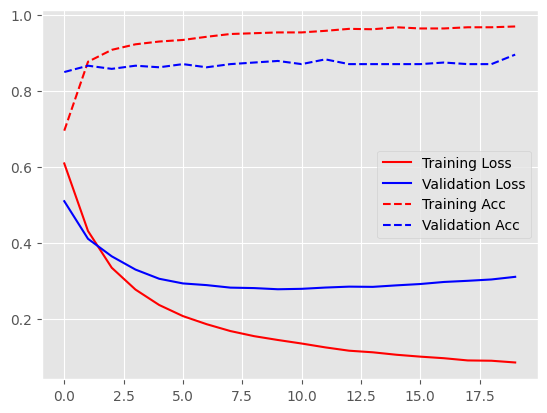

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

#*Transformer /w Attention Layer*

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    output_mode="int", # This is requesting multihot encodings (which means we'll have a fixed vector of 1's and 0's per review)
)

text_vectorization.adapt(trip_advisor_text)

processed_text = text_vectorization(trip_advisor_text)

# We have 1,600 reviews, with 2000 dummies for our vocab.
print(processed_text.shape)

(1600, 784)


We can leverage the code from the book for a Transformer of course.

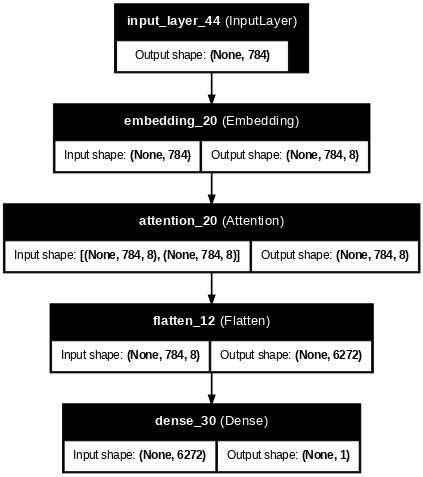

In [ ]:
from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda, Dense

def build_attention_model():
    # Now, let's start specifying our model...
    inputs = keras.layers.Input(shape=(784,)) # We take the sequence of 1-hot encodings as input.

    embedding_layer = layers.Embedding(784,8)
    embeddings = embedding_layer(inputs)

    attention = keras.layers.Attention()([embeddings,embeddings])

    flatten = keras.layers.Flatten()(attention)

    outputs = keras.layers.Dense(1, activation="sigmoid")(flatten)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

attention_model = build_attention_model()
keras.utils.plot_model(attention_model,show_shapes=True,dpi=60,show_layer_names=True)

We have max length of 2000 terms, and thus one-hot encodings means we have

In [ ]:
data_train = processed_text[:1200]
labels_train = label[:1200]

data_test = processed_text[1200:]
labels_test = label[1200:]

callbacks = [
    keras.callbacks.ModelCheckpoint("attention_model.keras",
                                    save_best_only=True)
]

history = attention_model.fit(data_train, labels_train, # User calls .fit on model, not attention_model
                        validation_split=0.2,
                        epochs=20, batch_size=1,callbacks=callbacks)

Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5179 - loss: 0.7713 - val_accuracy: 0.5042 - val_loss: 0.6939
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4858 - loss: 0.7438 - val_accuracy: 0.5042 - val_loss: 0.6931
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5186 - loss: 0.7500 - val_accuracy: 0.4958 - val_loss: 0.7213
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5104 - loss: 0.7500 - val_accuracy: 0.5042 - val_loss: 0.6912
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4682 - loss: 0.7466 - val_accuracy: 0.4917 - val_loss: 0.6898
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5256 - loss: 0.7331 - val_accuracy: 0.6750 - val_loss: 0.6314
Epoch 7/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6369 - loss: 0.6549 - val_accuracy: 0.6875 - val_loss: 0.5743
Epoch 8/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7380 - loss: 0.5574 - val_accuracy: 0.

And plotting loss over training, and checking loss against test set... this model is also pretty good - it performs similarly, getting us to about 83% accuracy.

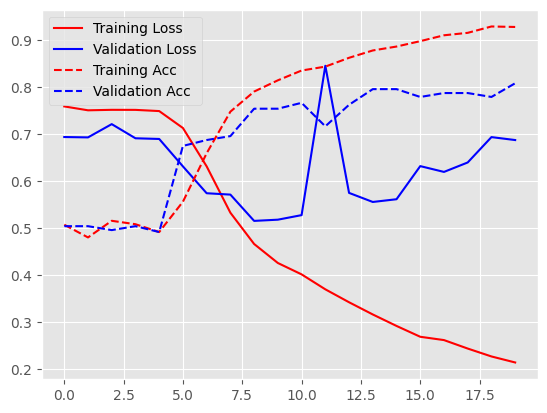

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()